In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
labels = ['Ulcer', 'Healthy']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/My Drive/DFU Dataset/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

    testPath = os.path.join('/content/drive/My Drive/DFU Dataset/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 110/110 [00:00<00:00, 138.69it/s]


<ipython-input-4-9c1c85090bd1>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


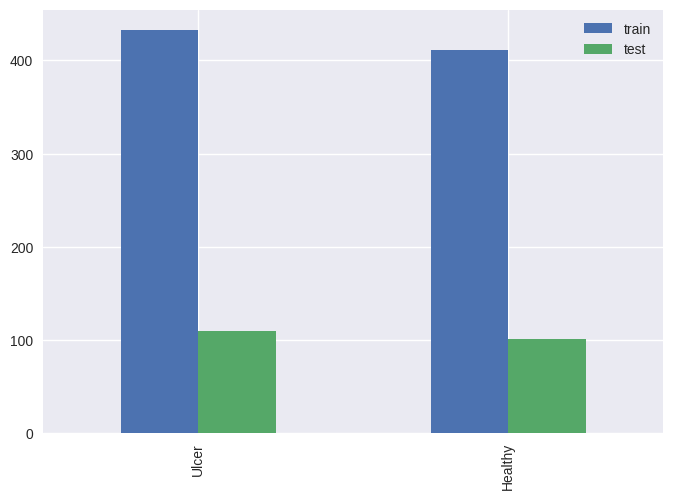

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
_, train_counts = np.unique(Y_train, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=labels
            ).plot.bar()
plt.savefig('dataset',dpi=400)
plt.show()

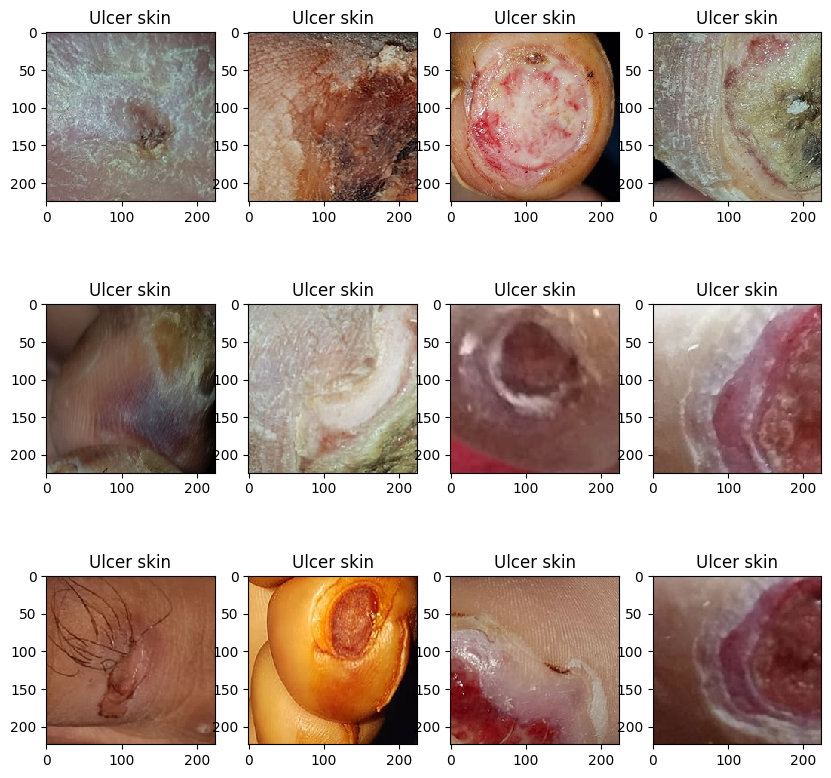

In [ ]:
plt.style.use('default')
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Healthy skin')
    else:
        ax.title.set_text('Ulcer skin')
    plt.imshow(X_train[i], interpolation='nearest')
plt.savefig('samples',dpi=400)
plt.show()

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1010)
X_train.shape

(844, 224, 224, 3)

In [ ]:
X_test, Y_test = shuffle(X_test, Y_test, random_state=1010)
X_test.shape

(211, 224, 224, 3)

In [ ]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1010)
X_val.shape

(85, 224, 224, 3)

In [ ]:
X_train.shape

(759, 224, 224, 3)

In [ ]:
import sys
y = np.array([70, 10, 20])
mylabels = ["Train (70%)", "Validation (10%)", "Test (20%)"]
myexplode = [0.1, 0.1, 0]

plt.pie(y, labels = mylabels, explode = myexplode, shadow = False)
plt.legend(title = "DFU Dataset Splitting")
plt.savefig('ratio',dpi=400)
plt.show()

In [ ]:
input_shape = (image_size, image_size, 3)
inputs = Input(input_shape)

dense   = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
nas      = tf.keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
multi_net = Concatenate()([GlobalAveragePooling2D()(dense), GlobalAveragePooling2D()(nas), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(multi_net)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
predicts = Dense(2, activation='softmax')(outputs)
model = Model(inputs, predicts)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, 7, 7, 1920)   18321984    ['input_1[0][0]']                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 1056)   4269716     ['input_1[0][0]']                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_1[0][0]']            

In [ ]:
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
datagen = ImageDataGenerator(
zoom_range=2,  # set range for random zoom
rotation_range = 90,
shear_range = 0.4,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

In [ ]:
train_generator=datagen.flow_from_directory('/content/drive/My Drive/DFU Final Dataset', target_size=(224,224), color_mode='rgb', shuffle=False, subset='training', batch_size=32, class_mode='categorical')
val_generator = datagen.flow_from_directory('/content/drive/My Drive/DFU Final Dataset', target_size=(224,224), color_mode='rgb', shuffle=False, subset='validation', batch_size=32, class_mode='categorical')

Found 1600 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), steps_per_epoch=X_train.shape[0] / 32,
                              validation_data=(X_val, Y_val), epochs=50,
                              callbacks=[learn_control, checkpoint])

<ipython-input-17-d2cac84f44e2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), steps_per_epoch=X_train.shape[0] / 32,


Epoch 1/50
24/23 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8511

23/23 [==============================] - 161s 3s/step - loss: 0.3896 - accuracy: 0.8511 - val_loss: 1.7182 - val_accuracy: 0.4118 - lr: 1.0000e-04
Epoch 2/50
24/23 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9578

23/23 [==============================] - 31s 1s/step - loss: 0.1484 - accuracy: 0.9578 - val_loss: 0.8848 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/50
24/23 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9657

23/23 [==============================] - 31s 1s/step - loss: 0.1180 - accuracy: 0.9657 - val_loss: 0.1464 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 4/50
24/23 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9723

23/23 [==============================] - 31s 1s/step - loss: 0.0915 - accuracy: 0.9723 - val_loss: 0.2183 - val_accuracy: 0.9176 - lr: 1.0000e-04
Epoch 5/50
24/23 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9736

23/23 [==============================] - 32s 1s/step - loss: 0.0900 - accuracy: 0.9736 - val_loss: 0.0745 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 6/50
24/23 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9750

23/23 [==============================] - 31s 1s/step - loss: 0.0742 - accuracy: 0.9750 - val_loss: 0.1371 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 7/50
24/23 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9671

23/23 [==============================] - 32s 1s/step - loss: 0.0917 - accuracy: 0.9671 - val_loss: 0.0367 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 8/50
24/23 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9618

23/23 [==============================] - 32s 1s/step - loss: 0.1015 - accuracy: 0.9618 - val_loss: 0.0490 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 9/50
24/23 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9697

23/23 [==============================] - 31s 1s/step - loss: 0.0819 - accuracy: 0.9697 - val_loss: 0.0821 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 10/50
24/23 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9697

23/23 [==============================] - 31s 1s/step - loss: 0.1022 - accuracy: 0.9697 - val_loss: 0.6286 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 11/50
24/23 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9671

23/23 [==============================] - 31s 1s/step - loss: 0.1064 - accuracy: 0.9671 - val_loss: 0.0649 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/50
24/23 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9868

23/23 [==============================] - 31s 1s/step - loss: 0.0617 - accuracy: 0.9868 - val_loss: 0.1003 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 13/50
24/23 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9750

23/23 [==============================] - 31s 1s/step - loss: 0.0681 - accuracy: 0.9750 - val_loss: 0.0241 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 14/50
24/23 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9723

23/23 [==============================] - 32s 1s/step - loss: 0.0867 - accuracy: 0.9723 - val_loss: 0.0481 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 15/50
24/23 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9750

23/23 [==============================] - 31s 1s/step - loss: 0.0759 - accuracy: 0.9750 - val_loss: 0.0208 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/50
24/23 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9776

23/23 [==============================] - 32s 1s/step - loss: 0.0771 - accuracy: 0.9776 - val_loss: 0.0391 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 17/50
24/23 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9855

23/23 [==============================] - 31s 1s/step - loss: 0.0557 - accuracy: 0.9855 - val_loss: 0.0333 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/50
24/23 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9789

23/23 [==============================] - 32s 1s/step - loss: 0.0661 - accuracy: 0.9789 - val_loss: 0.0422 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/50
24/23 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9816

23/23 [==============================] - 32s 1s/step - loss: 0.0562 - accuracy: 0.9816 - val_loss: 0.0120 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/50
24/23 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9816

23/23 [==============================] - 32s 1s/step - loss: 0.0482 - accuracy: 0.9816 - val_loss: 0.0172 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 21/50
24/23 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9842

23/23 [==============================] - 31s 1s/step - loss: 0.0570 - accuracy: 0.9842 - val_loss: 0.0192 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 22/50
24/23 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9789

23/23 [==============================] - 32s 1s/step - loss: 0.0697 - accuracy: 0.9789 - val_loss: 0.0247 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 23/50
24/23 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9776

23/23 [==============================] - 31s 1s/step - loss: 0.0601 - accuracy: 0.9776 - val_loss: 0.0244 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 24/50
24/23 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9802

23/23 [==============================] - 32s 1s/step - loss: 0.0636 - accuracy: 0.9802 - val_loss: 0.0099 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/50
24/23 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9829

23/23 [==============================] - 32s 1s/step - loss: 0.0485 - accuracy: 0.9829 - val_loss: 0.1220 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 26/50
24/23 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9829

23/23 [==============================] - 32s 1s/step - loss: 0.0431 - accuracy: 0.9829 - val_loss: 0.0172 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 27/50
24/23 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9855

23/23 [==============================] - 32s 1s/step - loss: 0.0524 - accuracy: 0.9855 - val_loss: 0.0088 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 28/50
24/23 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9895

23/23 [==============================] - 32s 1s/step - loss: 0.0407 - accuracy: 0.9895 - val_loss: 0.0125 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 29/50
24/23 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9921

23/23 [==============================] - 32s 1s/step - loss: 0.0214 - accuracy: 0.9921 - val_loss: 0.0089 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 30/50
24/23 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9842

23/23 [==============================] - 32s 1s/step - loss: 0.0397 - accuracy: 0.9842 - val_loss: 0.0253 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 31/50
24/23 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9776

23/23 [==============================] - 32s 1s/step - loss: 0.0597 - accuracy: 0.9776 - val_loss: 0.0283 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 32/50
24/23 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9802

23/23 [==============================] - 32s 1s/step - loss: 0.0620 - accuracy: 0.9802 - val_loss: 0.0812 - val_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 33/50
24/23 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9829

23/23 [==============================] - 31s 1s/step - loss: 0.0476 - accuracy: 0.9829 - val_loss: 0.0087 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 34/50
24/23 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9829

23/23 [==============================] - 32s 1s/step - loss: 0.0446 - accuracy: 0.9829 - val_loss: 0.0060 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 35/50
24/23 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9868

23/23 [==============================] - 32s 1s/step - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.0170 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 36/50
24/23 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9816

23/23 [==============================] - 32s 1s/step - loss: 0.0461 - accuracy: 0.9816 - val_loss: 0.0077 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 37/50
24/23 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9816

23/23 [==============================] - 32s 1s/step - loss: 0.0587 - accuracy: 0.9816 - val_loss: 0.0089 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 38/50
24/23 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9868

23/23 [==============================] - 31s 1s/step - loss: 0.0438 - accuracy: 0.9868 - val_loss: 0.0226 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 39/50
24/23 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9842

23/23 [==============================] - 32s 1s/step - loss: 0.0534 - accuracy: 0.9842 - val_loss: 0.0603 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 40/50
24/23 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9816

23/23 [==============================] - 32s 1s/step - loss: 0.0470 - accuracy: 0.9816 - val_loss: 0.0280 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 41/50
24/23 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9934

23/23 [==============================] - 31s 1s/step - loss: 0.0303 - accuracy: 0.9934 - val_loss: 0.0110 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 42/50
24/23 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9855

23/23 [==============================] - 32s 1s/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0145 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 43/50
24/23 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9881

23/23 [==============================] - 31s 1s/step - loss: 0.0327 - accuracy: 0.9881 - val_loss: 0.0371 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 44/50
24/23 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9789

23/23 [==============================] - 32s 1s/step - loss: 0.0565 - accuracy: 0.9789 - val_loss: 0.0668 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 45/50
24/23 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9868

23/23 [==============================] - 32s 1s/step - loss: 0.0429 - accuracy: 0.9868 - val_loss: 0.0282 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 46/50
24/23 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9855

23/23 [==============================] - 32s 1s/step - loss: 0.0438 - accuracy: 0.9855 - val_loss: 0.0443 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 47/50
24/23 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9868

23/23 [==============================] - 32s 1s/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.0206 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 48/50
24/23 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9776

23/23 [==============================] - 32s 1s/step - loss: 0.0633 - accuracy: 0.9776 - val_loss: 0.0157 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 49/50
24/23 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9816

23/23 [==============================] - 31s 1s/step - loss: 0.0516 - accuracy: 0.9816 - val_loss: 0.0292 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 50/50
24/23 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9855

23/23 [==============================] - 32s 1s/step - loss: 0.0385 - accuracy: 0.9855 - val_loss: 0.0159 - val_accuracy: 0.9882 - lr: 1.0000e-04


<ipython-input-18-895c47eec362>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


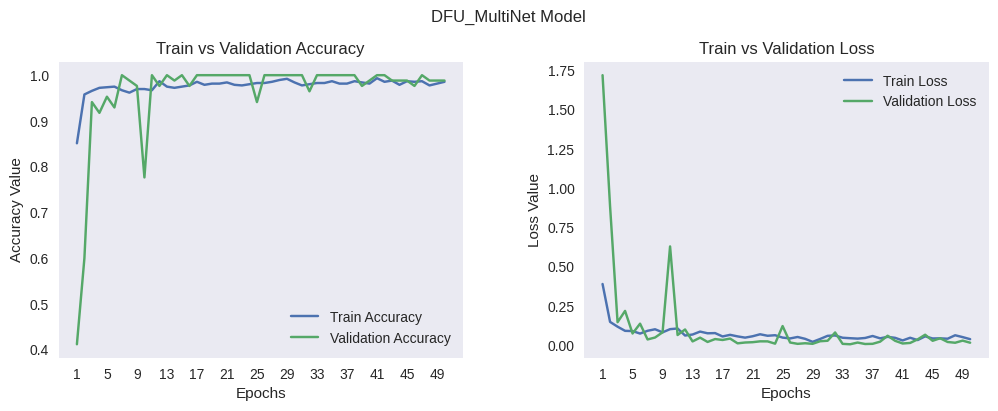

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DFU_MultiNet Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epochs')
ax1.set_title('Train vs Validation Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epochs')
ax2.set_title('Train vs Validation Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve',dpi=400)

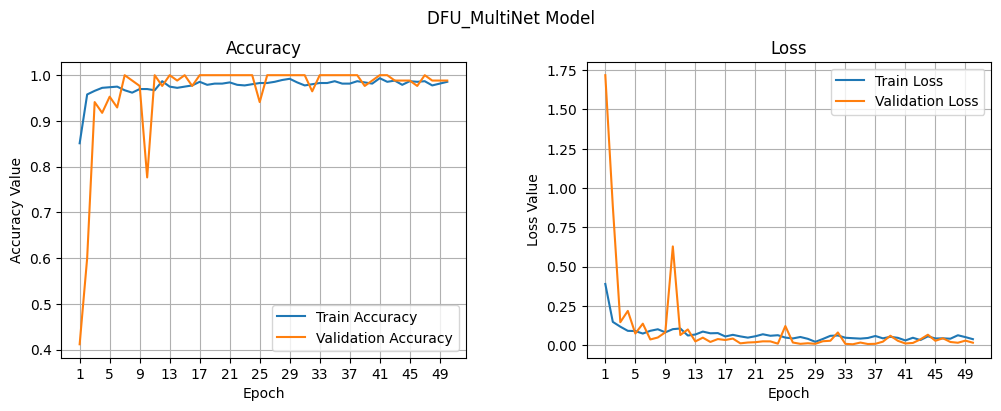

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DFU_MultiNet Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)
print(classification_report(y_test_new,pred))

7/7 [==============================] - 16s 1s/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       1.00      0.98      0.99       110

    accuracy                           0.99       211
   macro avg       0.99      0.99      0.99       211
weighted avg       0.99      0.99      0.99       211



Confusion matrix, without normalization
[[101   0]
 [  2 108]]


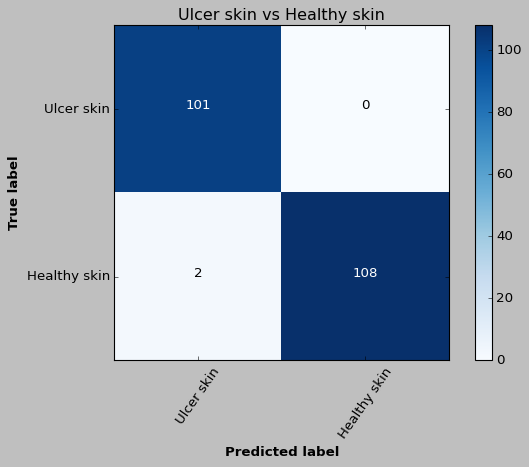

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test_new,pred)

cm_plot_label =['Ulcer skin', 'Healthy skin']
plot_confusion_matrix(cm, cm_plot_label, title ='Ulcer skin vs Healthy skin')
plt.savefig('CM',dpi=400)

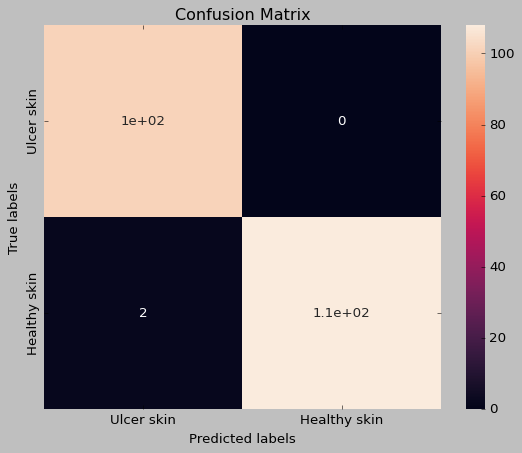

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Ulcer skin', 'Healthy skin']); ax.yaxis.set_ticklabels(['Ulcer skin', 'Healthy skin'])
plt.savefig('CM_heatmap',dpi=400)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,matthews_corrcoef,cohen_kappa_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred),
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred),'MCC: %.3f' % matthews_corrcoef(y_test_new, pred),
      'Kappa: %.3f' % cohen_kappa_score(y_test_new, pred))

Accuracy: 0.991 Precision: 1.000  Recall: 0.982 F1 Score: 0.991 AUC Score: 0.991 MCC: 0.981 Kappa: 0.981


In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 108.000000 TN: 101.000000 FP: 0.000000 FN: 2.000000


In [ ]:
specificity=TN/float(TN+FP)
print('Specificity: %.3f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.3f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.3f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.3f' % f1)
print( 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.3f' % mean_squared_error(y_test_new, pred))
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

print('MCC: %.3f' % matthews_corrcoef(y_test_new, pred), 'Kappa: %.3f' % cohen_kappa_score(y_test_new, pred))

Specificity: 1.000
 Recall: 0.982
 Precision: 1.000
F1 Score: 0.991
AUC Score: 0.991
Error Rate: 0.009
MCC: 0.981 Kappa: 0.981


<ipython-input-26-cdb2474e4756>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


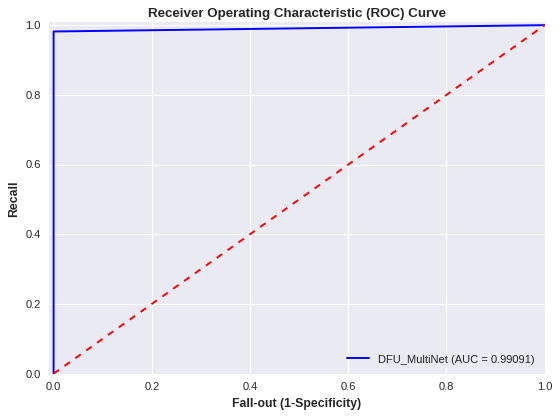

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'DFU_MultiNet (AUC = %0.5f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve11',dpi=400)
plt.show()

In [ ]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Accuracy: 99.05%
Precision: 100.00%
Recall or Sensitivity: 98.18%
Specificity: 100.00%
F1-score: 99.08%
AUC-score: 99.09%
Train acc: 98.55%


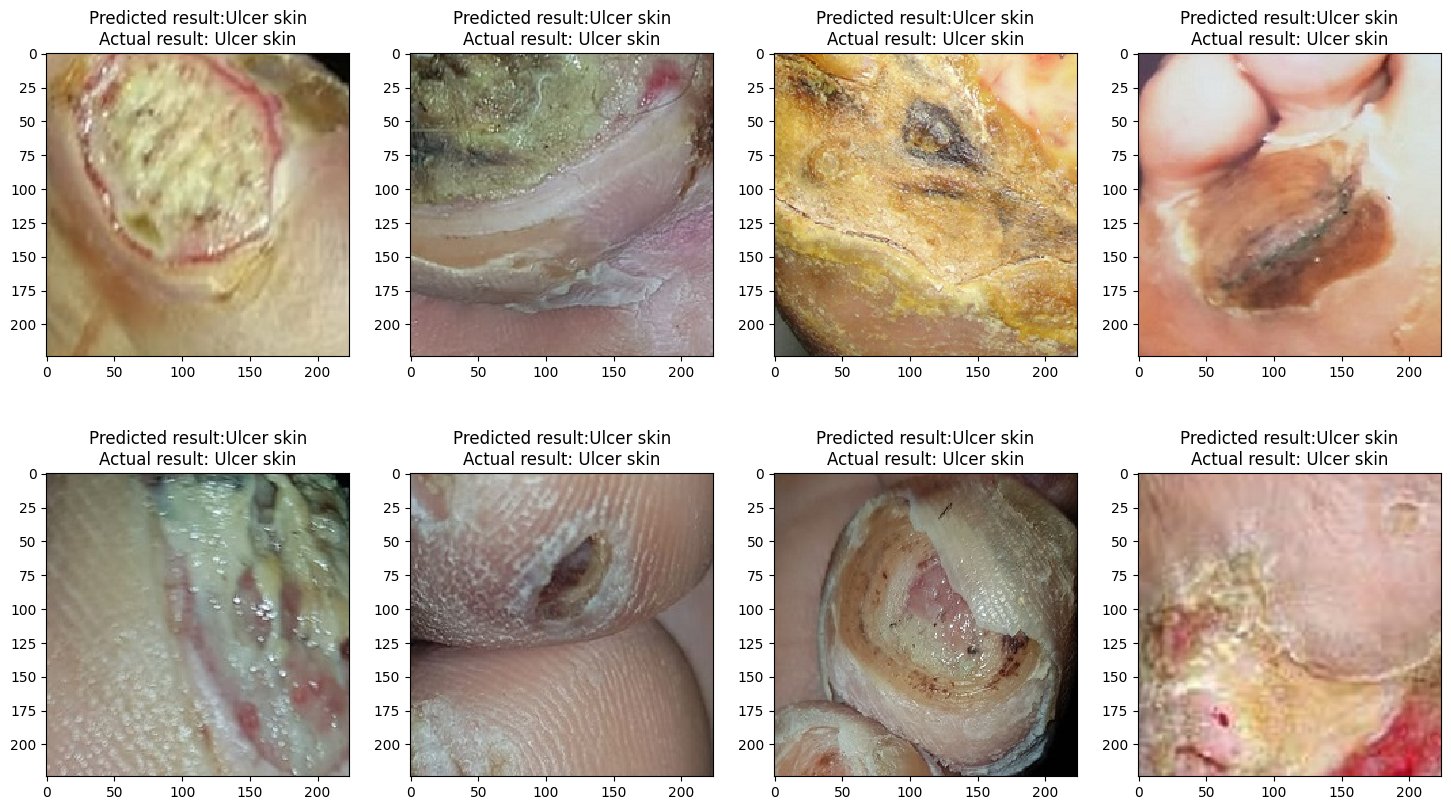

In [ ]:
plt.style.use('default')
i=0
prop_class=[]
mis_class=[]
#pred = np.argmax(pred,axis=1)
#y_test_new = np.argmax(Y_test,axis=1)
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Healthy skin"
    else:
        return "Ulcer skin"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.savefig('prediction',dpi=400)
plt.show()